PROGETTO MACHINE LEARNING STROKE PREDICTION

L'obiettivo di questo progetto è quello di sviluppare un algoritmo di Machine Learning per prevedere se un paziente rischia di essere colpito da ictus dati dei parametri di input (features).

IMPORTAZIONI E EDA (EXPLORING DATA ANALYSIS)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Warnings.
import warnings
warnings.filterwarnings("ignore")

from matplotlib.pyplot import figure
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

#Lettura file CSV (nostro dataset)
ds_stroke = pd.read_csv('dataset/healthcare-dataset-stroke-data.csv' ,\
     index_col = False , sep=',')
cols = ds_stroke.columns.values

print(ds_stroke.info())
print(ds_stroke.describe())
#print(ds_stroke.head(3))
print(cols)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354   

Il Dataset Stroke è costituito da 12 features e 5110 campioni. Fin da subito controlliamo se nel dataset sono presenti elementi nulli e possiamo vedere come ci siano 201 valori della colonna "bmi" contenente elementi nulli che bisogna opportunatamente gestire.
Inoltre, guardando l'output della info() possiamo notare come 5 delle 12 features siano di tipo object. Successivamente verificheremo i valori assunti da tali features e se sia il caso di eseguire una dummizzaione.

In [2]:
#Drop della colonna "id"
ds_stroke = ds_stroke.drop('id', axis=1)
#print(ds_stroke.info())
print(ds_stroke.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Per la gestione dei NaN nella colonna ibm ho preferito sostituire i valori mancanti con la media dei valori presenti in quella colonna, invece di droppare direttamente le righe per evitare la perdita di informazioni.

In [3]:
#sostituzioni valori NaN
ds_stroke.bmi.fillna(ds_stroke.bmi.mean(),inplace=True)
#Check elementi nulli dataset dopo sostituzione
print(ds_stroke.isnull().sum())
#print(ds_stroke.head())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


Una delle feature di tipo object è la colonna "gender". Ora vado a controllare i valori assunti da questa feature.

['Male' 'Female' 'Other']
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


<Axes: xlabel='gender', ylabel='Count'>

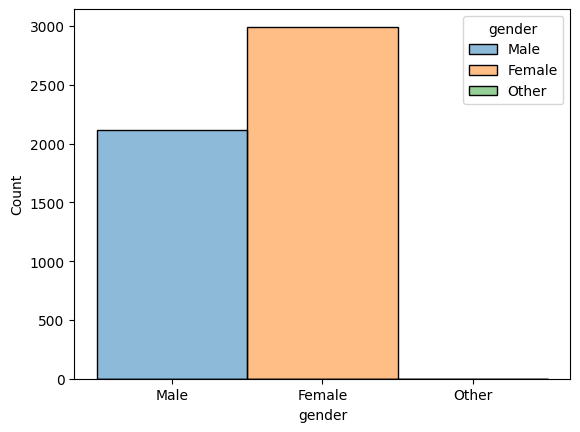

In [4]:
print(ds_stroke['gender'].unique())
print(ds_stroke['gender'].value_counts())

#Istogramma
sns.histplot(data=ds_stroke , hue="gender" , x = 'gender')


Dato che tra tutti i valorio assunti da gender c'è nè solo uno che assume valore Other decido di dropparlo perchè non c'è una perdita significativa di informazioni.

<Axes: xlabel='gender', ylabel='Count'>

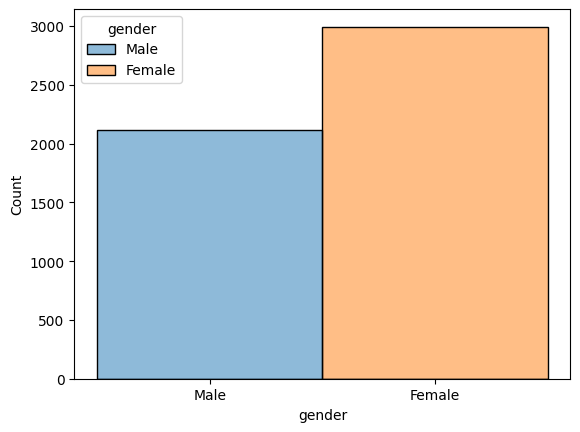

In [5]:
ds_stroke.drop(ds_stroke[ds_stroke['gender']=='Other'].index , inplace=True)
sns.histplot(data=ds_stroke , hue="gender" , x = 'gender')

CALCOLO CORRELATION MATRIX

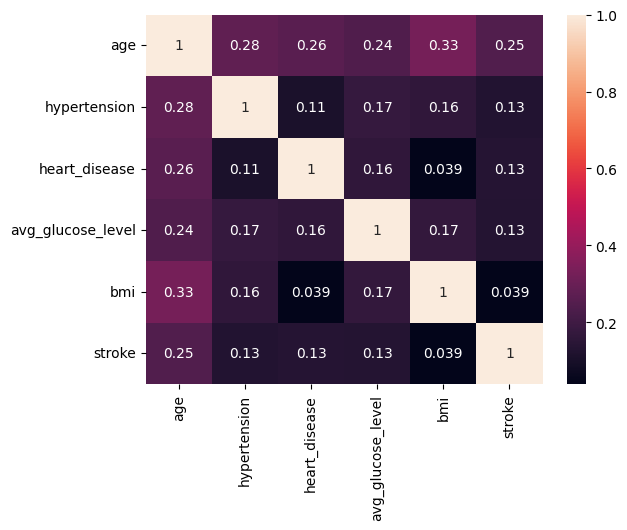

In [6]:
corr_matrix = ds_stroke.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.show()

Dalla Correlation Matrix possiamo vedere come non ci siano feature altamente correlate o scollerate tra loro. Questo significa che non abbiamo feature che ci danno le stesse informazioni e quindi non possono essere droppate.

Ora utilizzaremo delle tecniche di Hot encoding e label encoding per andare a dummizare la feature gender

In [7]:
#Procediamo dummizzando le 5 features di tipo object: 
#print(ds_stroke.info())
#columns_to_encode = ["gender" ,"ever_married","work_type","Residence_type","smoking_status"]
#ds_stroke = pd.get_dummies(ds_stroke , columns=columns_to_encode)
#print(ds_stroke.head(5))


In [8]:
#Ricalcolo Correlation Matrix dopo dummizzazione
#figure(figsize=(18,16) , dpi = 100)
#corr_1_df = ds_stroke.corr()
#sns.heatmap(corr_1_df , annot=True)
#plt.show()

Controllo feature SMOKING_STATUS


smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64


<Axes: xlabel='smoking_status', ylabel='Count'>

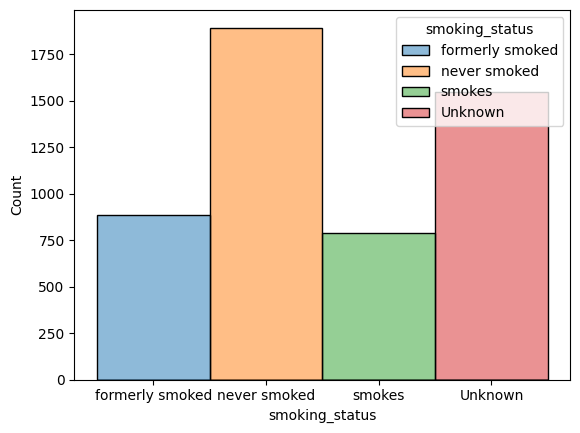

In [9]:
#print(ds_stroke['smoking_status'])
print(ds_stroke['smoking_status'].value_counts())


#Rappresentiamo graficamente quello appena visto:
sns.histplot(data=ds_stroke , hue="smoking_status" , x = 'smoking_status')


Check numerical features


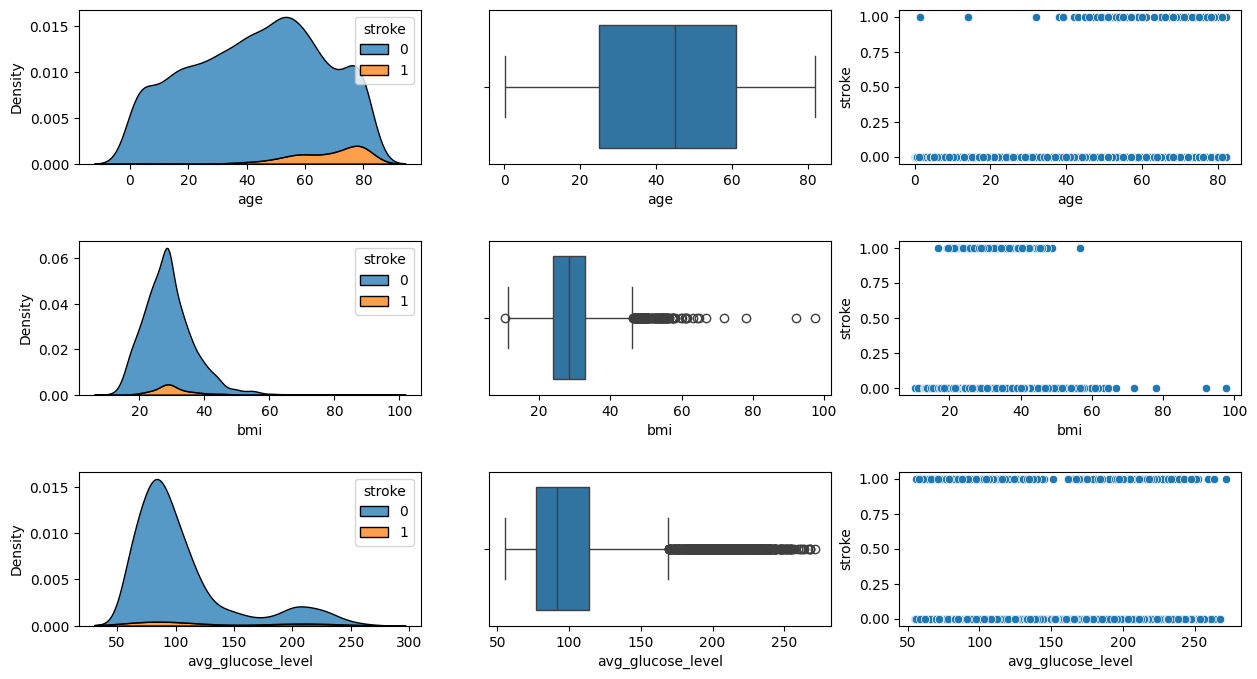

In [10]:
numeric_columns = ['age', 'bmi', 'avg_glucose_level']

i = 0
fig, ax = plt.subplots(3, 3, figsize=(15, 8))
plt.subplots_adjust(hspace = 0.5)
for num_col in numeric_columns :
    sns.kdeplot(x=num_col, hue='stroke', data=ds_stroke, multiple='stack', ax=ax[i,0])
    sns.boxplot(x=num_col, data=ds_stroke, ax=ax[i, 1])
    sns.scatterplot(x=num_col, y='stroke', data=ds_stroke, ax=ax[i, 2])
    i+=1
plt.show()

Check categorical features

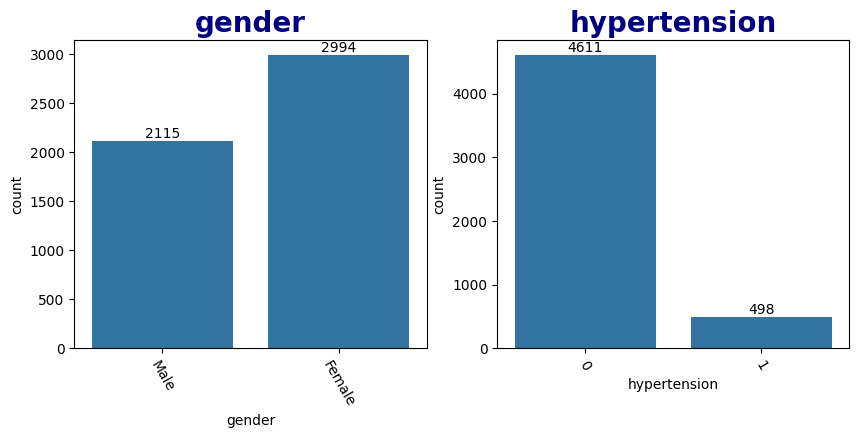

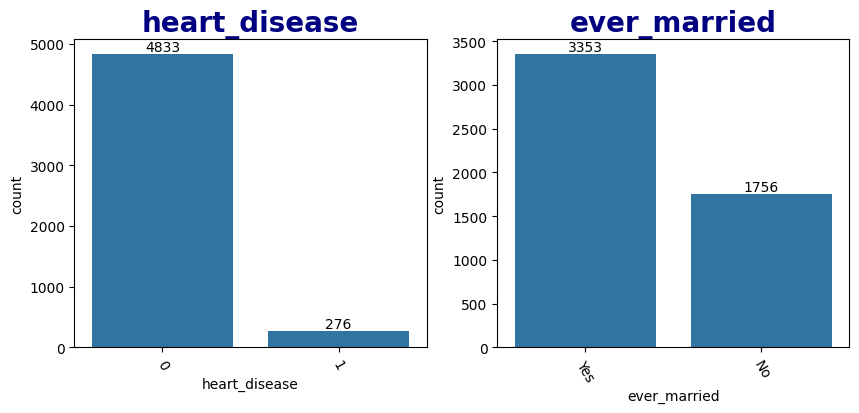

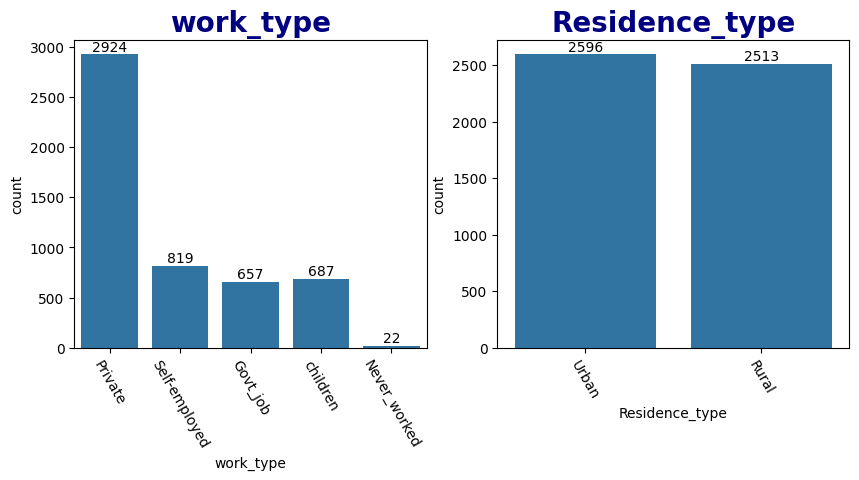

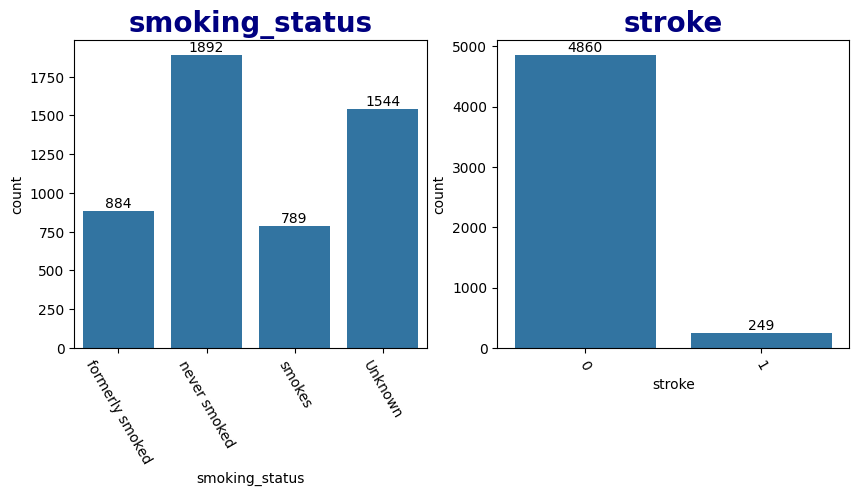

In [11]:
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

i=0
while i< len(categorical_columns) :
    
    # Left AX
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(categorical_columns[i], size=20, weight='bold', color='navy')
    ax = sns.countplot(x=categorical_columns[i], data=ds_stroke)
    ax.bar_label(ax.containers[0])
    ax.tick_params(axis='x', rotation=300)
    i+=1
    
    # Right AX
    plt.subplot(1, 2, 2)
    plt.title(categorical_columns[i], size=20, weight='bold', color='navy')
    ax = sns.countplot(x=categorical_columns[i], data=ds_stroke)
    ax.bar_label(ax.containers[0])
    ax.tick_params(axis='x', rotation=300)
    i+=1
    plt.show()



Confusion Matrix (Prima di farla dobbiamo dummizzare) P.S Chiedere a Giuseppe per sicurezza

In [12]:
#figure(figsize=(12,10) , dpi = 80)
#corr_ds_stroke = ds_stroke.corr()
#sns.heatmap(corr_ds_stroke , annot=True)
#plt.show()

Studio della feature stroke per vedere se dataset sbilanciato o meno.

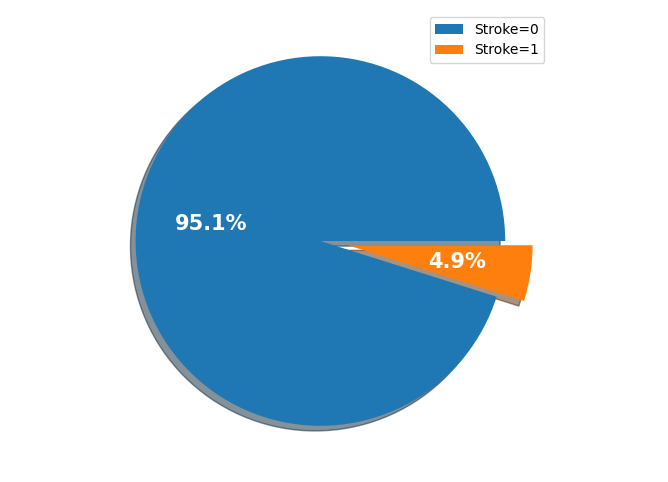

In [13]:
x = ds_stroke['stroke'].value_counts()

explode = [0, 0.15]
labels = ['Stroke=0', 'Stroke=1']
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

plt.pie(x, explode=explode, shadow=True, autopct='%1.1f%%', labels=labels, textprops=dict(color="w", weight='bold', size=15))
plt.legend()
plt.show()

In [14]:
#Pairplot
#Effettuo un Pairplot:
sns.pairplot(ds_stroke , hue="stroke")
plt.show()

Usare K-Fold al posto di Validation fisso